In [1]:
from typing import List
from typing import Tuple
from typing import Dict
from typing import Any

import os
import json
from collections import defaultdict
from collections import OrderedDict

import numpy as np
import pandas as pd
import sklearn as sk
import statsmodels as sm

%matplotlib inline
import matplotlib.pyplot as plt

import statsmodels.tsa
import statsmodels.tsa.seasonal
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf 
from statsmodels.graphics.tsaplots import plot_pacf

In [2]:
sleep_df: pd.Timestamp = pd.read_feather('data/processed/fitness_df.feather')
sleep_df.set_index('date', inplace=True)

IMG_ROOT: str = "export/images/exploration/"
os.makedirs(IMG_ROOT, exist_ok=True)

TBL_ROOT: str = "export/tables/"
os.makedirs(TBL_ROOT, exist_ok=True)

## Data Visualizations

In [3]:
sleep_df.head()

sleep  awake  inbed  bed_time  rise_time  sleep_score  \
date                                                                
2023-01-27  225.0   38.0  263.0  3.383333   7.775000           67   
2023-01-28  397.0   54.0  451.0  2.058333   9.583333           82   
2023-01-29  386.0   34.0  420.0  0.541667   7.541667           83   
2023-01-30  337.0   70.0  407.0  0.191667   6.983333           72   
2023-01-31  631.0  125.0  756.0 -0.258333  12.341667           75   

            calories_today  stress_today  upper_pressure_today  \
date                                                             
2023-01-27         3501.51     71.860465            121.333333   
2023-01-28         3872.51     71.000000            121.333333   
2023-01-29         3810.67     70.000000            121.333333   
2023-01-30         3566.75     64.000000            121.333333   
2023-01-31         3676.57     66.000000            121.333333   

            lower_pressure_today  walk_today  distance_today  \
date                                                           
2023-01-27             78.777778     18547.0       1383590.0   
2023-01-28             78.777778     18519.0       1381320.0   
2023-01-29             78.777778     25897.0       1932110.0   
2023-01-30             78.777778     16226.0       1210620.0   
2023-01-31             78.777778     26014.0       1939840.0   

            n_intermediate_wake_ups  readiness_score  calories_before_sleep  \
date                                                                          
2023-01-27                        1              0.0            3443.431899   
2023-01-28                        1              0.0            3501.510000   
2023-01-29                        0              0.0            3872.510000   
2023-01-30                        2              1.0            3810.670000   
2023-01-31                        6              1.0            3566.750000   

            stress_before_sleep  walk_before_sleep  distance_before_sleep  
date                                                                       
2023-01-27            71.844420       19145.205426           1.428152e+06  
2023-01-28            71.860465       18547.000000           1.383590e+06  
2023-01-29            71.000000       18519.000000           1.381320e+06  
2023-01-30            70.000000       25897.000000           1.932110e+06  
2023-01-31            64.000000       16226.000000           1.210620e+06

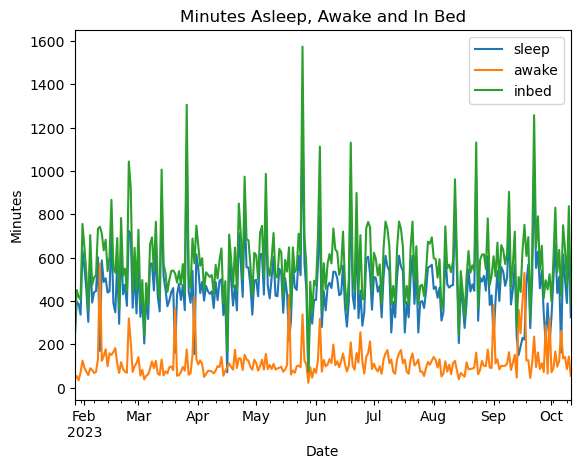

In [4]:
sleep_df[['sleep', 'awake', 'inbed']].plot()
plt.title('Minutes Asleep, Awake and In Bed')
plt.ylabel("Minutes")
plt.xlabel("Date")
plt.savefig(os.path.join(IMG_ROOT, "minutes_asleep_awake_inbed.png"))
plt.show()

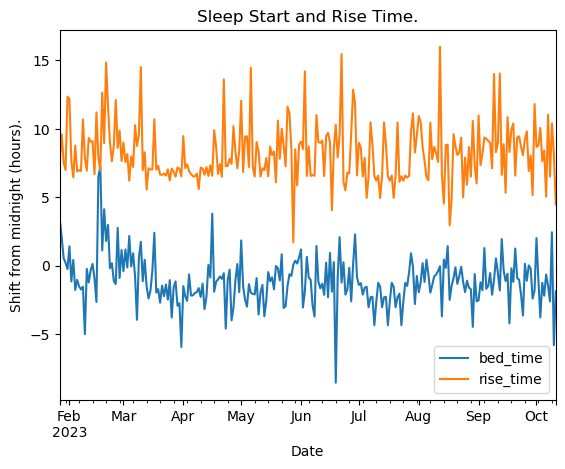

In [5]:
sleep_df[['bed_time', 'rise_time']].plot()
plt.title("Sleep Start and Rise Time.")
plt.ylabel("Shift from midnight (hours).")
plt.xlabel("Date")
plt.savefig(os.path.join(IMG_ROOT, "sleep_start_and_rise_time.png"))
plt.show()

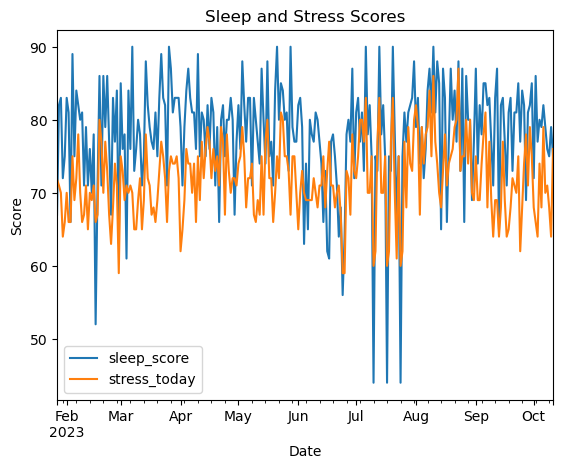

In [6]:
sleep_df[['sleep_score', 'stress_today']].plot()
plt.title("Sleep and Stress Scores")
plt.ylabel('Score')
plt.xlabel("Date")
plt.savefig(os.path.join(IMG_ROOT, "sleep_and_stress_scores.png"))
plt.show()

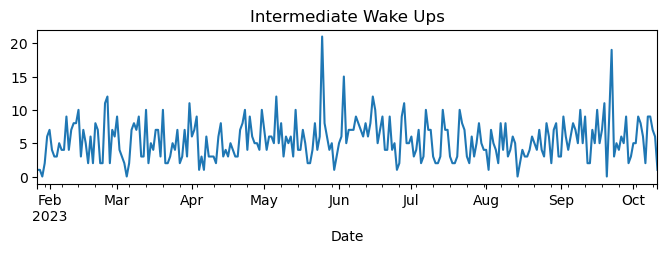

In [7]:
plt.figure(figsize=(8, 2))
sleep_df['n_intermediate_wake_ups'].plot()
plt.title("Intermediate Wake Ups")
plt.xlabel("Date")
plt.savefig(os.path.join(IMG_ROOT, "intermediate_wake_ups.png"))
plt.show()

In [8]:
np.mean(sleep_df['n_intermediate_wake_ups'])

5.449612403100775

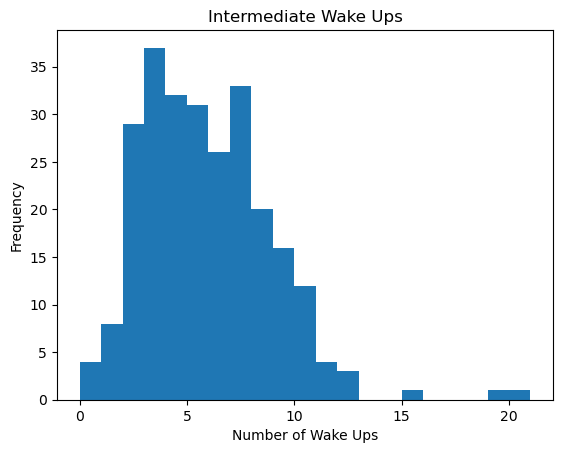

In [9]:
plt.hist(sleep_df['n_intermediate_wake_ups'], 21)
plt.title("Intermediate Wake Ups")
plt.xlabel("Number of Wake Ups")
plt.ylabel("Frequency")
plt.savefig(os.path.join(IMG_ROOT, "histogram_n_wake_ups.png"))
plt.show()

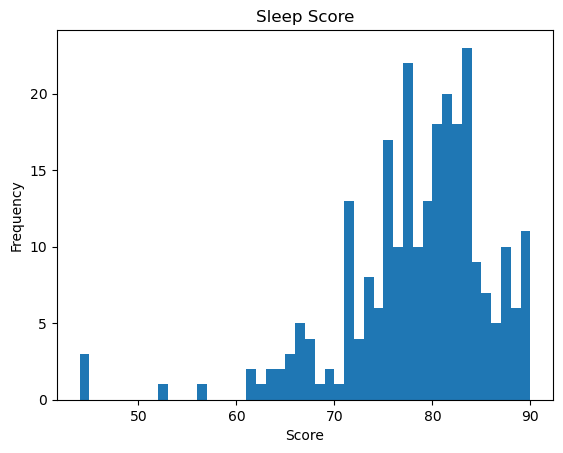

In [10]:
plt.hist(sleep_df['sleep_score'], 46)
plt.ylabel("Frequency")
plt.xlabel("Score")
plt.title("Sleep Score")
plt.savefig(os.path.join(IMG_ROOT, "hist_sleep_score.png"))
plt.show()

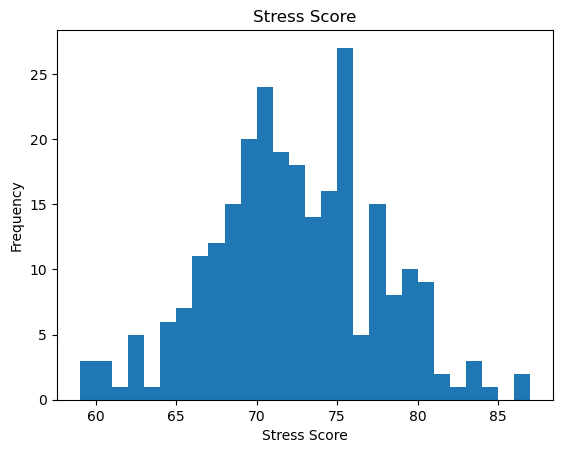

In [11]:
plt.hist(sleep_df['stress_today'], 28)
plt.title("Stress Score")
plt.ylabel("Frequency")
plt.xlabel("Stress Score")
plt.savefig(os.path.join(IMG_ROOT, "hist_stress_score.png"))
plt.show()

## Statistical Observations

In [12]:
def build_confidence_interval(measurements: List[float]) -> Tuple[float, float, float]:
    """ Builds 95% confidence interval. 
    
    Args:
        measurements: List with observations.
    
    Returns:
        Tuple with three elements: average value, start of the 
        confidence segment, end of the confidence segment.
    """
    n_observations: int = len(measurements)
    mean_value: float = np.mean(measurements)
    std_value: float = np.mean(measurements)
    confidence_constant: float = 1.96
    lhs_value: float = mean_value - confidence_constant * std_value / np.sqrt(n_observations)
    rhs_value: float = mean_value + confidence_constant * std_value / np.sqrt(n_observations)
    return mean_value, lhs_value, rhs_value

In [13]:
class ConfidenceBuilder:
    """ Builder for the table with statistics and confidence intervals.
    
    Attributes:
        title_list: List with observation titles.
        average_list: List with average values.
        interval_list: List with confidence intervals.
    """
    def __init__(self) -> None:
        """ Initializer method. """
        self.title_list: List[str] =  list()
        self.average_list: List[str] = list()
        self.interval_list: List[str] = list()
    
    def register_entry(self, title: str, mean_value: float, lhs_value: float, rhs_value: float) -> None:
        """ Registers information about the new observation.
        
        Args:
            title: The measurement name.
            mean_value: The average value.
            lhs_value: The left part of the confidence interval.
            rhs_value: The right part of the confidence interval.
        """
        self.title_list.append(title)
        self.average_list.append(f"{mean_value:.2f}")
        self.interval_list.append(f"[{lhs_value:.2f}, {rhs_value:.2f}]")
        self.report_observation(title, mean_value, lhs_value, rhs_value)
    
    def report_observation(self, title: str, mean_value: float, lhs_value: float, rhs_value: float) -> None:
        """ Prints information about the new observation. 
        
        Args:
            title: The measurement name.
            mean_value: The average value.
            lhs_value: The left part of the confidence interval.
            rhs_value: The right part of the confidence interval.
        """
        print(f"Avg. {title}: {mean_value:.2f}, Confidence Interval: [{lhs_value:.2f}, {rhs_value:.2f}]")
        
    def make_table(self) -> pd.DataFrame:
        """ Creates Data Frame from the accumulated information.
        
        Returns:
            The created DataFrame.
        """
        return pd.DataFrame.from_dict(OrderedDict({
            "Parameter": self.title_list, 
            "Expected Value": self.average_list, 
            "Confidence Interval": self.interval_list
        }))

In [14]:
avg_value: float; lhs_value: float; rhs_value: float
table_builder: ConfidenceBuilder = ConfidenceBuilder()

In [15]:
avg_value, lhs_value, rhs_value = build_confidence_interval(sleep_df['sleep'])
table_builder.register_entry("Minutes Asleep", avg_value, lhs_value, rhs_value)

Avg. Minutes Asleep: 465.93, Confidence Interval: [409.08, 522.79]


In [16]:
avg_value, lhs_value, rhs_value = build_confidence_interval(sleep_df['awake'])
table_builder.register_entry("Minutes Awake", avg_value, lhs_value, rhs_value)

Avg. Minutes Awake: 118.84, Confidence Interval: [104.34, 133.34]


In [17]:
avg_value, lhs_value, rhs_value = build_confidence_interval(sleep_df['inbed'])
table_builder.register_entry("Minutes In Bed", avg_value, lhs_value, rhs_value)

Avg. Minutes In Bed: 584.78, Confidence Interval: [513.42, 656.13]


In [18]:
avg_value, lhs_value, rhs_value = build_confidence_interval(sleep_df['n_intermediate_wake_ups'])
table_builder.register_entry("Intermediate Wakeups ", avg_value, lhs_value, rhs_value)

Avg. Intermediate Wakeups : 5.45, Confidence Interval: [4.78, 6.11]


In [19]:
avg_value, lhs_value, rhs_value = build_confidence_interval(sleep_df['sleep_score'])
table_builder.register_entry("Sleep Score", avg_value, lhs_value, rhs_value)

Avg. Sleep Score: 78.03, Confidence Interval: [68.51, 87.56]


In [20]:
avg_value, lhs_value, rhs_value = build_confidence_interval(sleep_df['bed_time'])
table_builder.register_entry("Bed Time", avg_value, lhs_value, rhs_value)

Avg. Bed Time: -1.11, Confidence Interval: [-0.98, -1.25]


In [21]:
avg_value, lhs_value, rhs_value = build_confidence_interval(sleep_df['rise_time'])
table_builder.register_entry("Rise Time", avg_value, lhs_value, rhs_value)

Avg. Rise Time: 8.21, Confidence Interval: [7.20, 9.21]


In [22]:
avg_value, lhs_value, rhs_value = build_confidence_interval(sleep_df['calories_today'])
table_builder.register_entry("Calories Burnt", avg_value, lhs_value, rhs_value)

Avg. Calories Burnt: 3443.43, Confidence Interval: [3023.25, 3863.61]


In [23]:
avg_value, lhs_value, rhs_value = build_confidence_interval(sleep_df['stress_today'])
table_builder.register_entry("Stress Score", avg_value, lhs_value, rhs_value)

Avg. Stress Score: 71.84, Confidence Interval: [63.08, 80.61]


In [24]:
avg_value, lhs_value, rhs_value = build_confidence_interval(sleep_df['walk_today'])
table_builder.register_entry("Walk Steps", avg_value, lhs_value, rhs_value)

Avg. Walk Steps: 19145.21, Confidence Interval: [16809.03, 21481.39]


In [25]:
table_df: pd.DataFrame = table_builder.make_table()
table_df.to_excel(os.path.join(TBL_ROOT, 'confidence.xlsx'))
table_df

Parameter Expected Value   Confidence Interval
0         Minutes Asleep         465.93      [409.08, 522.79]
1          Minutes Awake         118.84      [104.34, 133.34]
2         Minutes In Bed         584.78      [513.42, 656.13]
3  Intermediate Wakeups            5.45          [4.78, 6.11]
4            Sleep Score          78.03        [68.51, 87.56]
5               Bed Time          -1.11        [-0.98, -1.25]
6              Rise Time           8.21          [7.20, 9.21]
7         Calories Burnt        3443.43    [3023.25, 3863.61]
8           Stress Score          71.84        [63.08, 80.61]
9             Walk Steps       19145.21  [16809.03, 21481.39]

## Data Correlations

In [26]:
src_sleep: np.array = np.array(sleep_df['sleep'])
src_calories: np.array = np.array(sleep_df['calories_before_sleep'])
src_awake: np.array = np.array(sleep_df['awake'])
src_inbed: np.array = np.array(sleep_df['inbed'])
src_n_wakes: np.array = np.array(sleep_df['n_intermediate_wake_ups'])
src_rise_time: np.array = np.array(sleep_df['rise_time'])
src_bed_time: np.array = np.array(sleep_df['bed_time'])

In [27]:
normalized_sleep: np.array = (src_sleep - np.mean(src_sleep)) / np.std(src_sleep)
normalized_calories: np.array = (src_calories - np.mean(src_calories)) / np.std(src_calories)
normalized_awake: np.array = (src_awake - np.mean(src_awake)) / np.std(src_awake)
normalized_inbed: np.array = (src_inbed - np.mean(src_inbed)) / np.std(src_inbed)
normalized_n_wakes: np.array = (src_n_wakes - np.mean(src_n_wakes)) / np.std(src_n_wakes)
normalized_rise_time: np.array = (src_rise_time - np.mean(src_rise_time)) / np.std(src_rise_time)
normalized_bed_time: np.array = (src_bed_time - np.mean(src_bed_time)) / np.std(src_bed_time)

In [28]:
norm_df: pd.DataFrame = pd.DataFrame.from_dict(OrderedDict({
    'normalized_sleep': normalized_sleep, 
    'normalized_calories': normalized_calories, 
    'normalized_awake': normalized_awake,
    'normalized_inbed': normalized_inbed,
    'normalized_n_wakes': normalized_n_wakes,
    'normalized_rise_time': normalized_rise_time,
    'normalized_bed_time': normalized_bed_time
}))

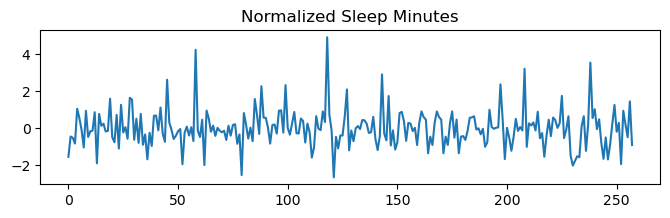

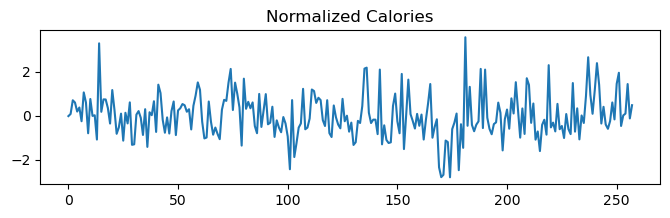

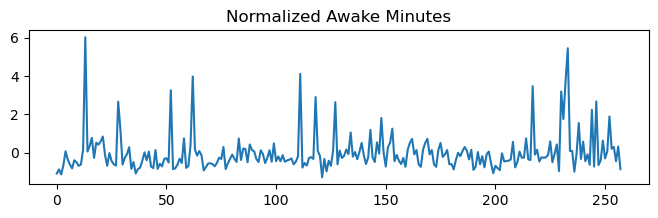

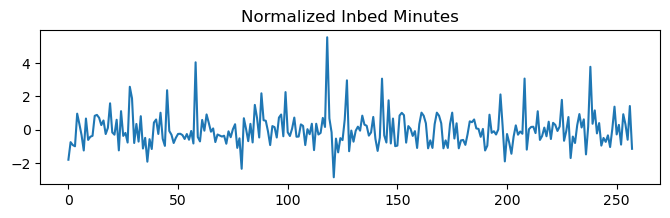

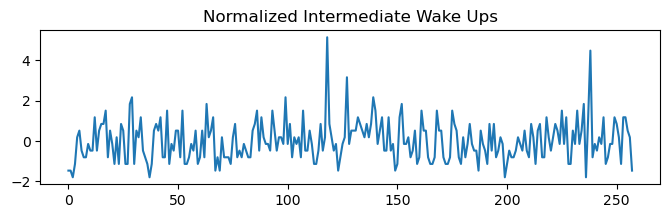

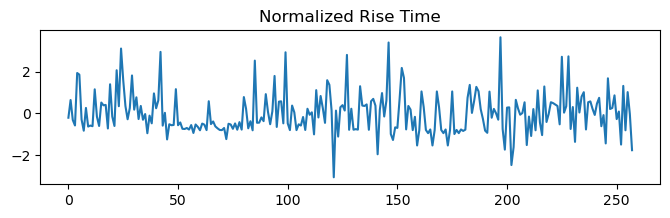

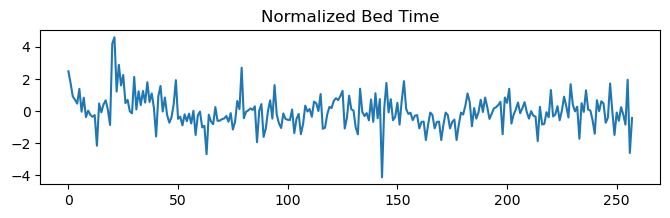

In [29]:
plt.figure(figsize=(8, 2))
plt.title('Normalized Sleep Minutes')
norm_df['normalized_sleep'].plot()

plt.figure(figsize=(8, 2))
plt.title("Normalized Calories")
norm_df['normalized_calories'].plot()

plt.figure(figsize=(8, 2))
plt.title('Normalized Awake Minutes')
norm_df['normalized_awake'].plot()

plt.figure(figsize=(8, 2))
plt.title('Normalized Inbed Minutes')
norm_df['normalized_inbed'].plot()

plt.figure(figsize=(8, 2))
plt.title('Normalized Intermediate Wake Ups')
norm_df['normalized_n_wakes'].plot()

plt.figure(figsize=(8, 2))
plt.title('Normalized Rise Time')
norm_df['normalized_rise_time'].plot()

plt.figure(figsize=(8, 2))
plt.title('Normalized Bed Time')
norm_df['normalized_bed_time'].plot()

plt.savefig(os.path.join(IMG_ROOT,"normalized_series.png"))
plt.show()

In [30]:
class CorrelationBuilder:
    """ Builder for the table with correlation information.
    
    Attributes:
        first_series: The names for the first series to compute correlations.
        second_series: The names for the second series to compute correlations.
        correlations: The corresponding correlation values (converted to strings).
    """
    def __init__(self) -> None:
        """ Initializer method. """
        self.first_series: List[str] = list()
        self.second_series: List[str] = list()
        self.correlations: List[str] = list()
    
    def register_entry(self, lhs_name: str, rhs_name: str, correlation: float) -> None:
        """ Registers information about computed correlation. 
        
        Args:
            lhs_name: The name of the first series to compute correlation.
            rhs_name: The name of the second series to compute correlation.
            correlation: The value of the computed correlation.
        """
        self.first_series.append(lhs_name)
        self.second_series.append(rhs_name)
        self.correlations.append(f"{correlation:.2f}")
        self.report_correlation(lhs_name, rhs_name, correlation)
    
    def report_correlation(self, lhs_name: str, rhs_name: str, correlation: float) -> None:
        """ Prints information about computed correlation. 
        
        Args:
            lhs_name: The name of the first series to compute correlation.
            rhs_name: The name of the second series to compute correlation.
            correlation: The value of the computed correlation.
        """
        print(f"Correlation between {lhs_name} and {rhs_name} is {correlation:.2f}.")
        
    def make_table(self) -> None:
        """ Makes the table from the accumulated information.
        
        Returns:
            The created dataframe.
        """
        return pd.DataFrame.from_dict(OrderedDict({
            "First Measurement": self.first_series,
            "Second Measurement": self.second_series,
            "Correlation": self.correlations
        }))

In [31]:
correlation_builder: CorrelationBuilder = CorrelationBuilder()
correlation_value: float

In [32]:
correlation_value = np.correlate(normalized_sleep, normalized_calories)[0]
correlation_builder.register_entry("Normalized Time Asleep", "Normalized Calories", correlation_value)
# More sport -> longer sleep.

Correlation between Normalized Time Asleep and Normalized Calories is 8.47.


In [33]:
correlation_value = np.correlate(normalized_awake, normalized_calories)[0] 
correlation_builder.register_entry("Normalized Time Awake", "Normalized Calories", correlation_value)
# More sport -> less time awake.

Correlation between Normalized Time Awake and Normalized Calories is -15.20.


In [34]:
correlation_value = np.correlate(normalized_n_wakes, normalized_inbed)[0]
correlation_builder.register_entry("Normalized Wake-up Count", "Normalized Time In Bed", correlation_value)
# Longer in bed -> more wakes up.

Correlation between Normalized Wake-up Count and Normalized Time In Bed is 174.38.


In [35]:
correlation_value = np.correlate(normalized_bed_time, normalized_sleep)[0]
correlation_builder.register_entry("Normalized Sleep Start", "Normalized Time Asleep", correlation_value)
# Later to bed -> less sleep. Makes sense if the wake up time is somewhat stable.

Correlation between Normalized Sleep Start and Normalized Time Asleep is -80.16.


In [36]:
correlation_df: pd.DataFrame = correlation_builder.make_table()
correlation_df.to_excel(os.path.join(TBL_ROOT, "correlations.xlsx"))
correlation_df

First Measurement      Second Measurement Correlation
0    Normalized Time Asleep     Normalized Calories        8.47
1     Normalized Time Awake     Normalized Calories      -15.20
2  Normalized Wake-up Count  Normalized Time In Bed      174.38
3    Normalized Sleep Start  Normalized Time Asleep      -80.16

## Autocorrelation Function

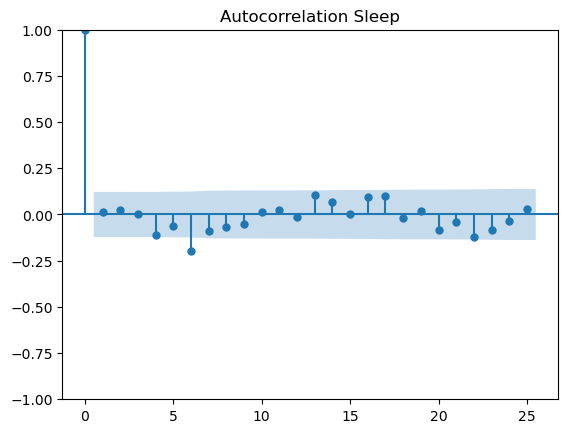

In [37]:
acf_img: Any = plot_acf(sleep_df.sleep.values)
plt.title("Autocorrelation Sleep")
plt.savefig(os.path.join(IMG_ROOT, "sleep_autocorrelation.png"))
plt.show()

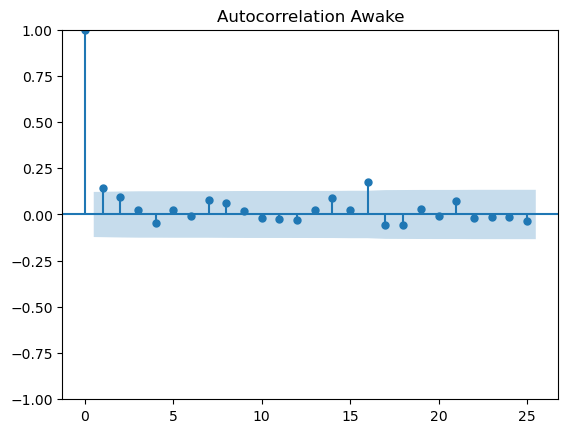

In [38]:
acf_img: Any = plot_acf(sleep_df.awake.values)
plt.title("Autocorrelation Awake")
plt.savefig(os.path.join(IMG_ROOT, "awake_acf.png"))
plt.show()

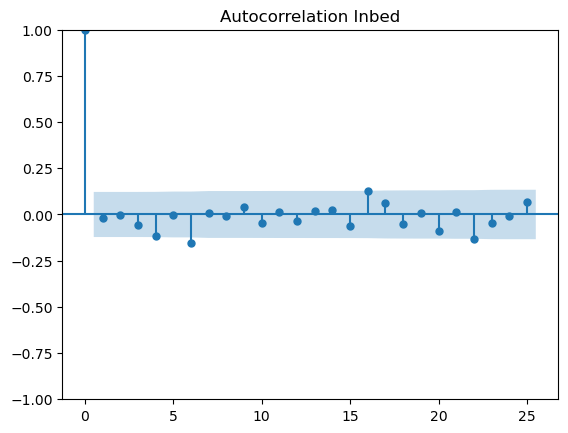

In [39]:
acf_img: Any = plot_acf(sleep_df.inbed.values)
plt.title("Autocorrelation Inbed")
plt.savefig(os.path.join(IMG_ROOT, "inbed_acf.png"))
plt.show()

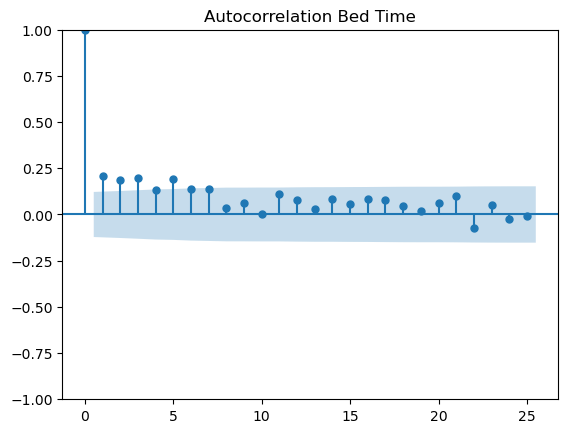

In [40]:
acf_img: Any = plot_acf(sleep_df.bed_time.values)
plt.title("Autocorrelation Bed Time")
plt.savefig(os.path.join(IMG_ROOT, 'bed_time_acf.png'))
plt.show()

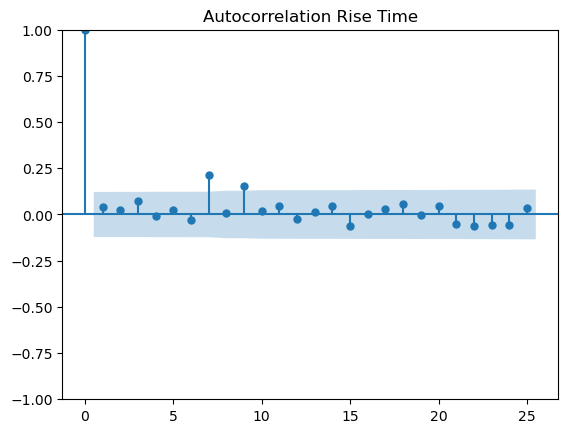

In [41]:
acf_img: Any = plot_acf(sleep_df.rise_time.values)
plt.title("Autocorrelation Rise Time")
plt.savefig(os.path.join(IMG_ROOT, 'rise_time_acf.png'))
plt.show()

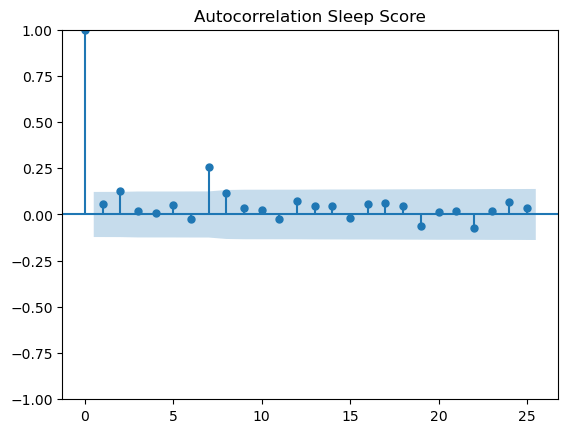

In [42]:
acf_img: Any = plot_acf(sleep_df.sleep_score.values)
plt.title("Autocorrelation Sleep Score")
plt.savefig(os.path.join(IMG_ROOT, 'sleep_score_acf.png'))
plt.show()

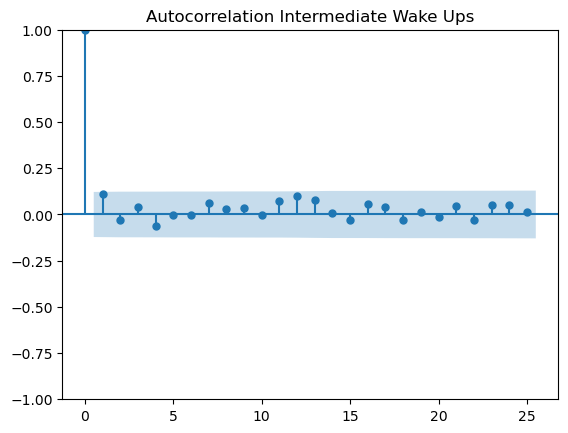

In [43]:
acf_img: Any = plot_acf(sleep_df.n_intermediate_wake_ups.values)
plt.title("Autocorrelation Intermediate Wake Ups")
plt.savefig(os.path.join(IMG_ROOT, 'n_wake_ups_acf.png'))
plt.show()

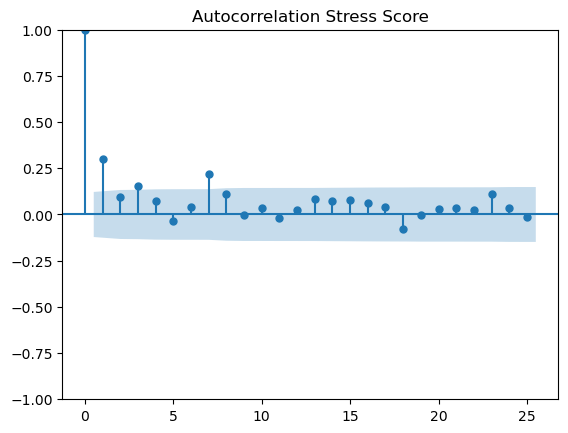

In [44]:
acf_img: Any = plot_acf(sleep_df.stress_today.values)
plt.title("Autocorrelation Stress Score")
plt.savefig(os.path.join(IMG_ROOT, 'stress_score_acf.png'))
plt.show()

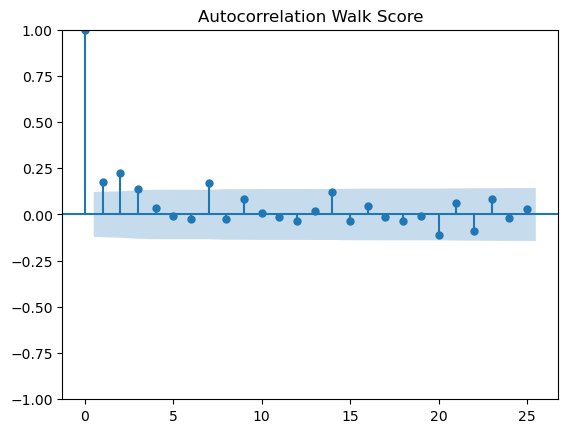

In [45]:
acf_img: Any = plot_acf(sleep_df.walk_today.values)
plt.title("Autocorrelation Walk Score")
plt.savefig(os.path.join(IMG_ROOT, 'walk_score_acf.png'))
plt.show()

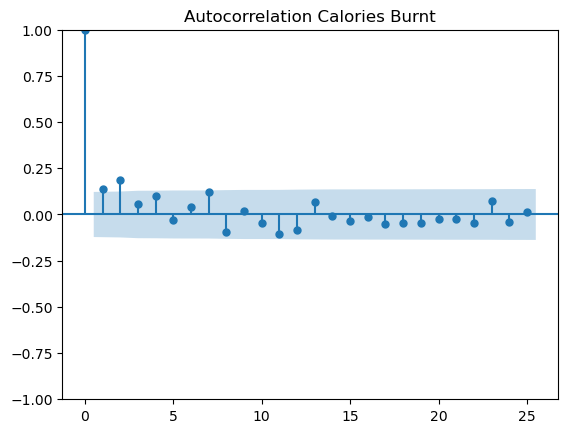

In [46]:
acf_img: Any = plot_acf(sleep_df.calories_today.values)
plt.title("Autocorrelation Calories Burnt")
plt.savefig(os.path.join(IMG_ROOT, 'calories_acf.png'))
plt.show()

## Seasonal Decompositions

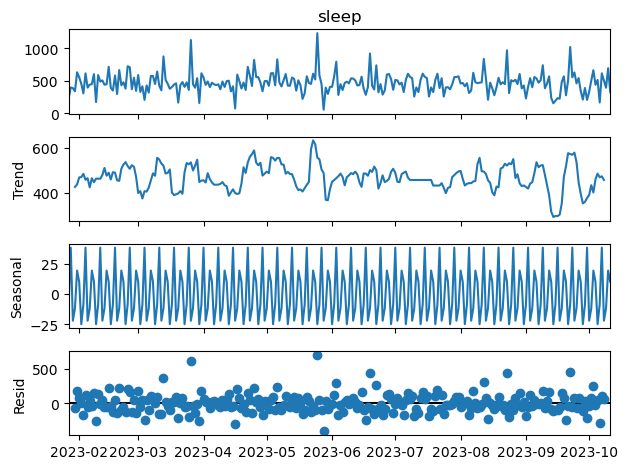

In [47]:
# Minutes Asleep
decomposition: Any
decomposition = statsmodels.tsa.seasonal.seasonal_decompose(
    sleep_df['sleep'], model='additive', period=7)
decomposition.plot()
plt.savefig(os.path.join(IMG_ROOT, 'sleep_decompose.png'))
plt.show()

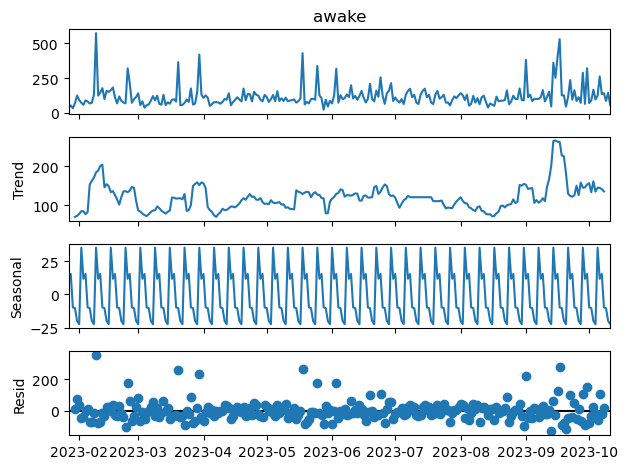

In [48]:
# Minutes Awake
decomposition = statsmodels.tsa.seasonal.seasonal_decompose(
    sleep_df['awake'], model='additive', period=7)
decomposition.plot()
plt.savefig(os.path.join(IMG_ROOT, 'awake_decompose.png'))
plt.show()

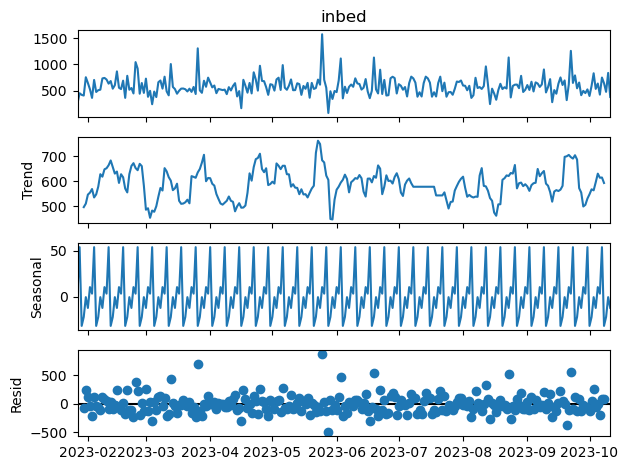

In [49]:
# Minutes Inbed
decomposition = statsmodels.tsa.seasonal.seasonal_decompose(
    sleep_df['inbed'], model='additive', period=7)
decomposition.plot()
plt.savefig(os.path.join(IMG_ROOT, 'inbed_decompose.png'))
plt.show()

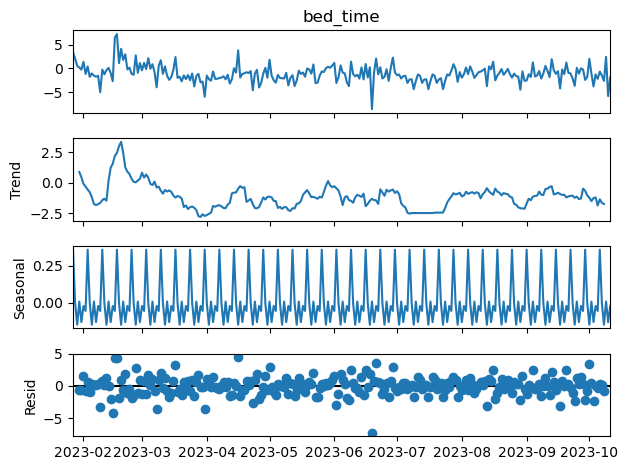

In [50]:
# Bed Time
decomposition = statsmodels.tsa.seasonal.seasonal_decompose(
    sleep_df['bed_time'], model='additive', period=7)
decomposition.plot()
plt.savefig(os.path.join(IMG_ROOT, 'bed_time_decompose.png'))
plt.show()

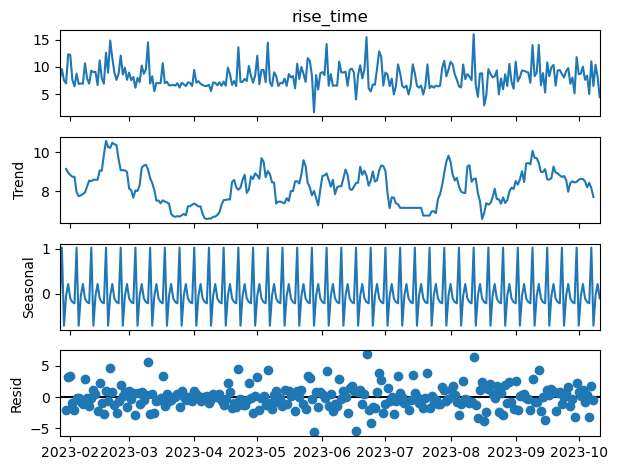

In [51]:
# Rise Time
decomposition = statsmodels.tsa.seasonal.seasonal_decompose(
    sleep_df['rise_time'], model='additive', period=7)
decomposition.plot()
plt.savefig(os.path.join(IMG_ROOT, 'rise_time_decompose.png'))
plt.show()

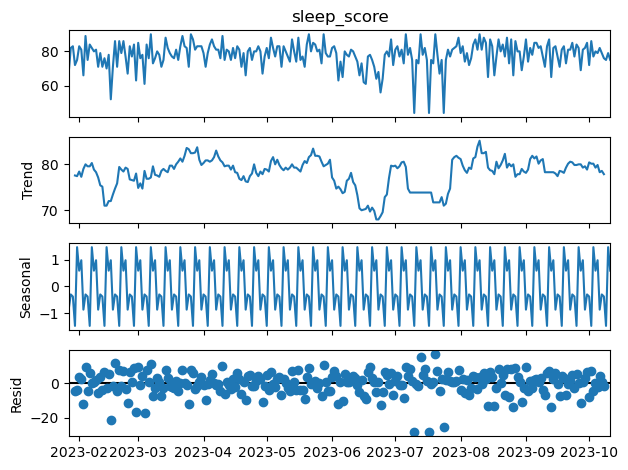

In [52]:
# Sleep Score
decomposition = statsmodels.tsa.seasonal.seasonal_decompose(
    sleep_df['sleep_score'], model='additive', period=7)
decomposition.plot()
plt.savefig(os.path.join(IMG_ROOT, 'sleep_score_decompose.png'))
plt.show()

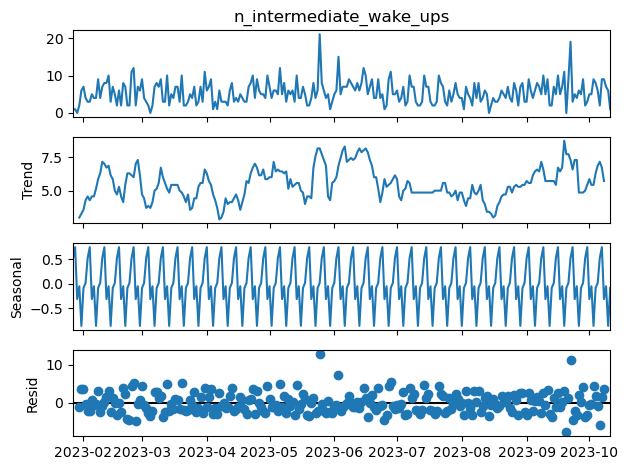

In [53]:
# Intermediate Wake Up Amount 
decomposition = statsmodels.tsa.seasonal.seasonal_decompose(
    sleep_df['n_intermediate_wake_ups'], model='additive', period=7)
decomposition.plot()
plt.savefig(os.path.join(IMG_ROOT, 'n_wake_ups_decompose.png'))
plt.show()

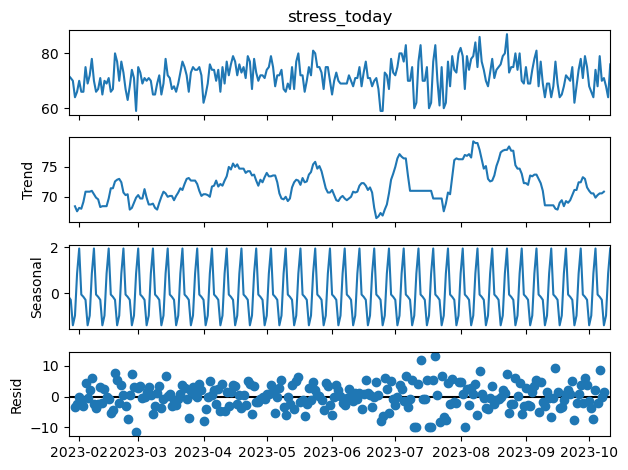

In [54]:
# Stress Score
decomposition = statsmodels.tsa.seasonal.seasonal_decompose(
    sleep_df['stress_today'], model='additive', period=7)
decomposition.plot()
plt.savefig(os.path.join(IMG_ROOT, 'stress_score_decompose.png'))
plt.show()

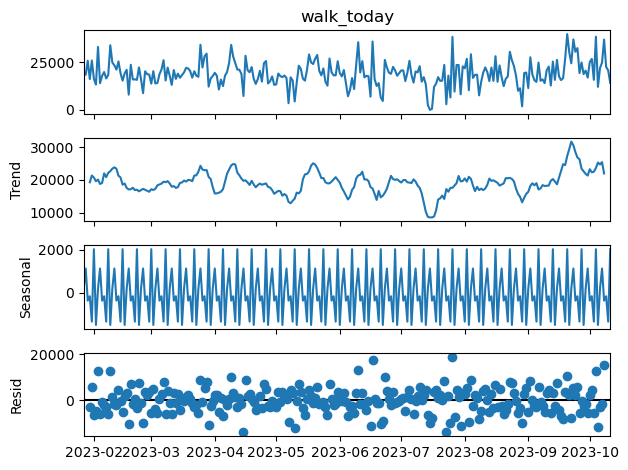

In [55]:
# Walk Today
decomposition = statsmodels.tsa.seasonal.seasonal_decompose(
    sleep_df['walk_today'], model='additive', period=7)
decomposition.plot()
plt.savefig(os.path.join(IMG_ROOT, 'walk_steps_decompose.png'))
plt.show()

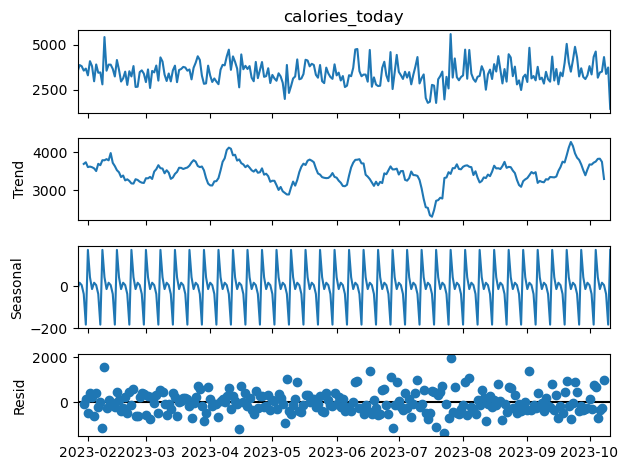

In [56]:
# Calories Burnt
decomposition = statsmodels.tsa.seasonal.seasonal_decompose(
    sleep_df['calories_today'], model='additive', period=7)
decomposition.plot()
plt.savefig(os.path.join(IMG_ROOT, 'burnt_calories_decompose.png'))
plt.show()

## STL Decompositions

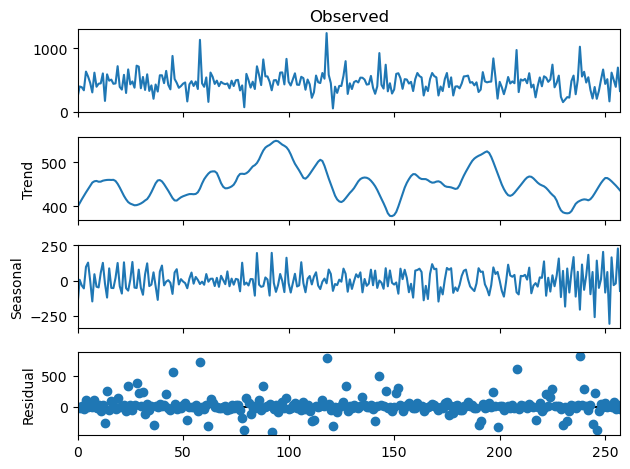

In [57]:
stl: Any
stl = STL(sleep_df['sleep'].values.reshape(-1), period=7, robust=True)
stl.fit().plot()
plt.savefig(os.path.join(IMG_ROOT, 'sleep_stl.png'))
plt.show()

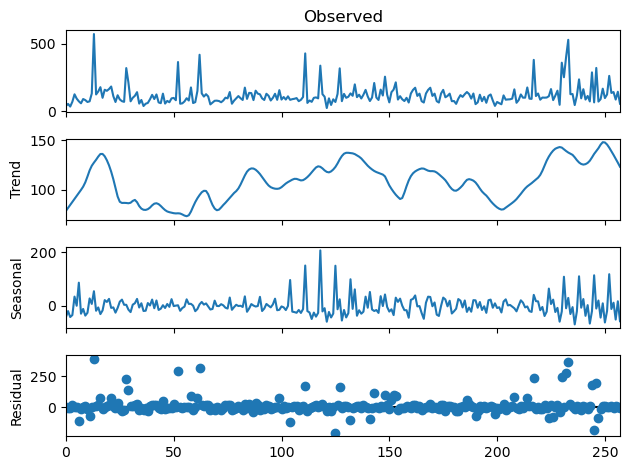

In [58]:
stl = STL(sleep_df['awake'].values.reshape(-1), period=7, robust=True)
stl.fit().plot()
plt.savefig(os.path.join(IMG_ROOT, 'awake_stl.png'))
plt.show()

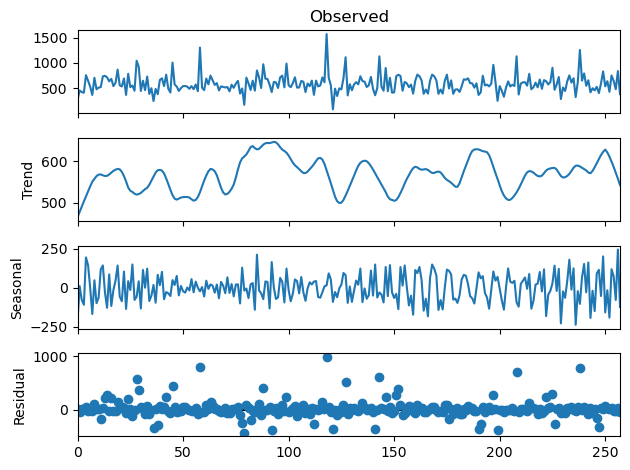

In [59]:
stl = STL(sleep_df['inbed'].values.reshape(-1), period=7, robust=True)
stl.fit().plot()
plt.savefig(os.path.join(IMG_ROOT, 'inbed_stl.png'))
plt.show()

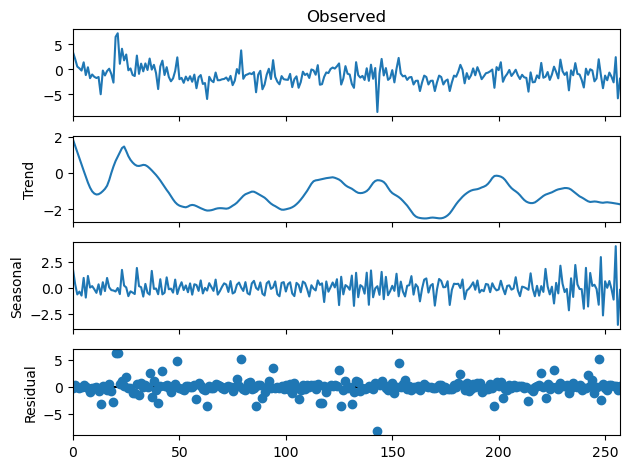

In [60]:
stl = STL(sleep_df['bed_time'].values.reshape(-1), period=7, robust=True)
stl.fit().plot()
plt.savefig(os.path.join(IMG_ROOT, 'bed_time_stl.png'))
plt.show()

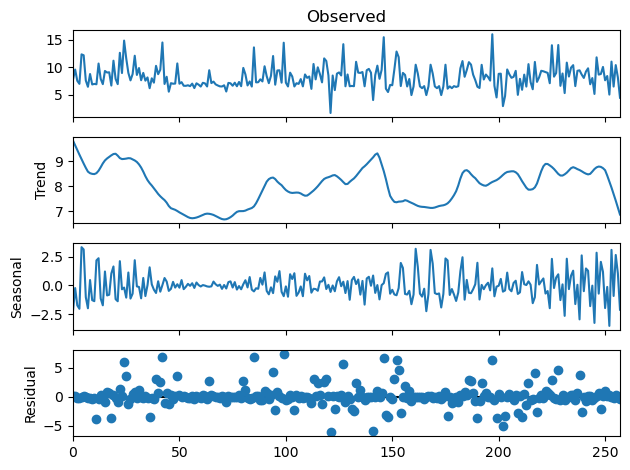

In [61]:
stl = STL(sleep_df['rise_time'].values.reshape(-1), period=7, robust=True)
stl.fit().plot()
plt.savefig(os.path.join(IMG_ROOT, 'rise_time_stl.png'))
plt.show()

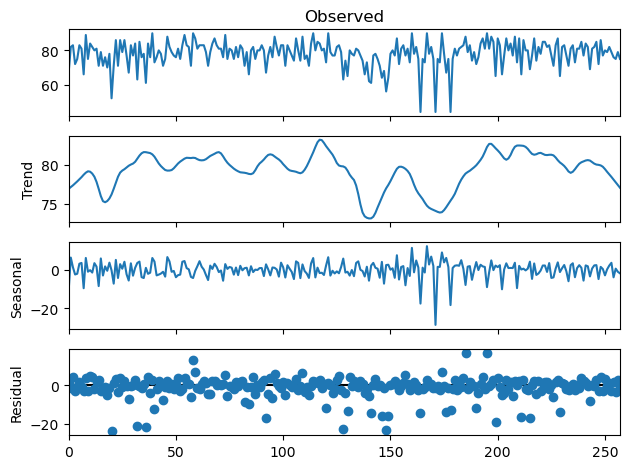

In [62]:
stl = STL(sleep_df['sleep_score'].values.reshape(-1), period=7, robust=True)
stl.fit().plot()
plt.savefig(os.path.join(IMG_ROOT, 'sleep_score_stl.png'))
plt.show()

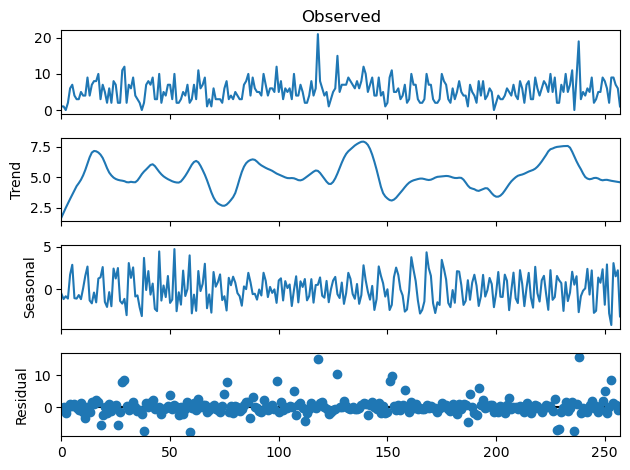

In [63]:
stl = STL(sleep_df['n_intermediate_wake_ups'].values.reshape(-1), period=7, robust=True)
stl.fit().plot()
plt.savefig(os.path.join(IMG_ROOT, 'n_wake_ups_stl.png'))
plt.show()

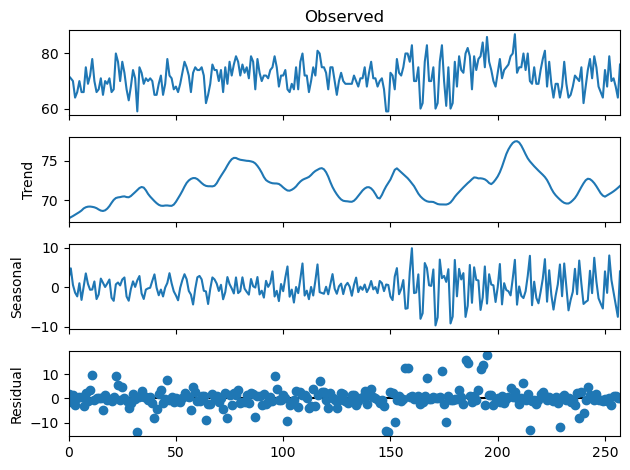

In [64]:
stl = STL(sleep_df['stress_today'].values.reshape(-1), period=7, robust=True)
stl.fit().plot()
plt.savefig(os.path.join(IMG_ROOT, 'stress_score_stl.png'))
plt.show()

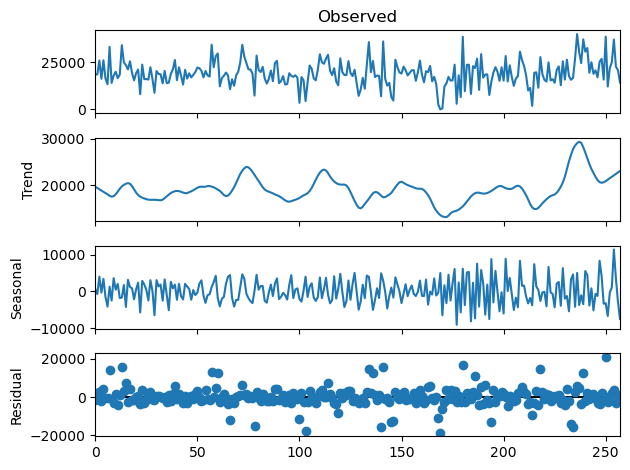

In [65]:
stl = STL(sleep_df['walk_today'].values.reshape(-1), period=7, robust=True)
stl.fit().plot()
plt.savefig(os.path.join(IMG_ROOT, 'walk_steps_stl.png'))
plt.show()

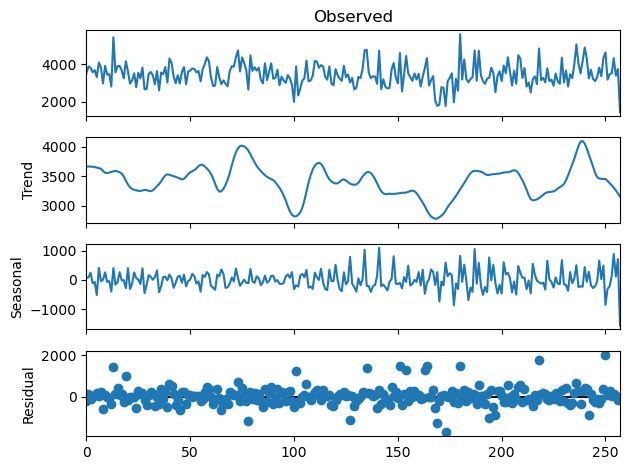

In [66]:
stl = STL(sleep_df['calories_today'].values.reshape(-1), period=7, robust=True)
stl.fit().plot()
plt.savefig(os.path.join(IMG_ROOT, 'calories_burnt_stl.png'))
plt.show()